Modelo de clasificador de autos, Gustavo Alfredo Zárate Acosta

In [ ]:
import numpy as np
import pandas as pd
import torch
import fastai.vision.all as fv
from torchvision.transforms import ToTensor, ToPILImage
import torch.nn as nn
from pathlib import Path
import torch.nn.functional as F
import random
import gc


to_tensor = ToTensor()
to_pil = ToPILImage()

/usr/local/lib/python3.6/dist-packages/fastcore/foundation.py:52: UserWarning: `patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead
  warnings.warn("`patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead")


In [ ]:
def getA(file):
    return float(file.name.split("_")[0])

def getF(file):
    return file.name.split("_")[1]

def getS(file):
    return file.name.split("_")[2]

In [ ]:
def load_data(file, img_size, batch_size):
    tfms = fv.aug_transforms(do_flip = False,
                             flip_vert = False,
                             max_rotate = 10,
                             max_lighting = 0.25,
                             max_zoom = 1.2,
                             max_warp = 0.1
                            )
    data = fv.DataBlock(blocks     = (fv.ImageBlock, fv.RegressionBlock, fv.CategoryBlock, fv.CategoryBlock),
                        n_inp      = 1,
                        get_items  = fv.get_image_files,
                        get_y      = [getA, getF, getS],
                        splitter   = fv.RandomSplitter(),
                        item_tfms  = fv.Resize(img_size),
                        batch_tfms = tfms
                       )
    return data.dataloaders(file, bs = batch_size)

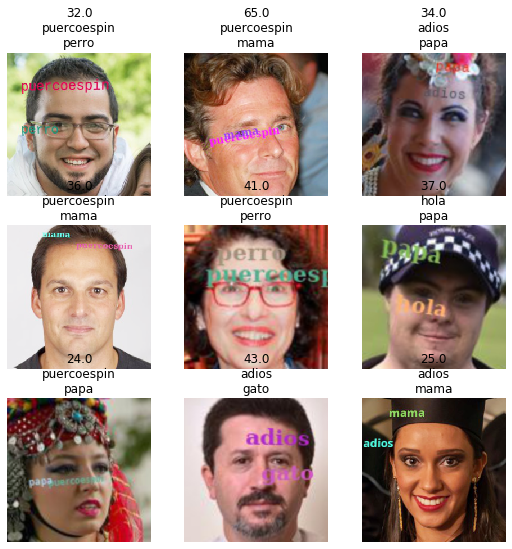

In [ ]:
data_source = Path("faces")
data = load_data( data_source, img_size = 256, batch_size = 64)
data.show_batch()

In [ ]:
class Normalizer(nn.Module):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        super().__init__()
        self.mean = torch.tensor(mean)[None, :, None, None]
        self.std = torch.tensor(std)[None, :, None, None]

    def forward(self, x):
        m = self.mean.to(x)
        s = self.std.to(x)
        return (x-m)/s

In [ ]:
class AgeLimiter(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sigmoid(x)*117-0.5

In [ ]:
class FullFlatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.reshape(-1)

In [ ]:
def Fsplitter(m):
    return fv.L(m[:6], m[6:-8], m[-8:]).map(fv.params)

In [ ]:
gc.collect()

17749

In [ ]:
def mse_flat(p, a):
    p = p.view(-1)
    return F.mse_loss(p,a)

def l1_flat(p, a):
    p = p.view(-1)
    return F.l1_loss(p, a)

def l1_plus_mse(p, a):
    return l1_flat(p, a) + mse_flat(p, a)/30

def age_loss(pred, age):
    a = 0.3
    p = (1 + pred)**a
    t = (1 + age)**a
    return torch.abs(p-t).mean()

In [ ]:
def FError(p, a, f, s):
    pA = p[:,0]
    pf = p[:,1:4]
    ps = p[:,4:]
    return l1_flat(pA,a)/10 + F.cross_entropy(pf,f) + F.cross_entropy(ps,s)

In [ ]:
#layers = list(fv.resnet18(pretrained = True).children())[:-1]
#layers += [fv.Flatten(), nn.Linear(512,8)]

In [ ]:
head = fv.create_head(1024, 8, ps=0.4)
head[5] = nn.LeakyReLU()

layers = [Normalizer()]
layers += list(fv.resnet18(pretrained = True).children())[:-2]
#layers += list(head)
#layers += [fv.Flatten(), nn.Linear(64,8)]
#layers += [fv.Flatten()]
layers += list(head)

In [ ]:
model = nn.Sequential(*layers)

In [ ]:
def l1_flatM(p, a, f, s):
    p = p[:,0].view(-1)
    return F.l1_loss(p, a)

In [ ]:
def sqrt_mse_flat(p, a, f, s):
    p = p[:,0].view(-1)
    return torch.sqrt(F.mse_loss(p,a))

In [ ]:
def accuracyF(p, a, f, s):
    return fv.accuracy(p[:,1:4],f)

In [ ]:
def accuracyS(p, a, f, s):
    return fv.accuracy(p[:,4:],s)

In [ ]:
learner = fv.Learner(data, model,
                     loss_func= FError, 
                     splitter = Fsplitter, 
                     opt_func = fv.ranger, 
                     metrics = [ sqrt_mse_flat, l1_flatM,accuracyF, accuracyS]
                    ).to_fp16()

SuggestedLRs(lr_min=2.7542287170945203e-07, lr_steep=7.585775847473997e-07)

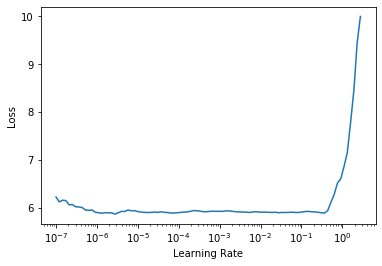

In [ ]:
learner.lr_find()

In [ ]:
learner.fit_one_cycle(25,10e-2, div=0.9,div_final=10000,pct_start=0.8)

epoch,train_loss,valid_loss,sqrt_mse_flat,l1_flatM,accuracyF,accuracyS,time
0,3.819620,3.798278,12.308827,9.974287,0.334927,0.253361,00:52
1,3.774359,3.873399,14.475518,10.597754,0.326860,0.233045,00:52
2,3.730664,3.675817,12.823642,9.378400,0.342695,0.250373,00:52
3,3.732703,3.540169,10.763073,8.299148,0.379146,0.238721,00:52
4,3.725303,4.081050,19.575865,15.037987,0.436510,0.256050,00:52
5,3.575301,3.610636,13.164572,9.882586,0.466687,0.247386,00:52
6,3.423060,3.684098,18.814457,14.455776,0.540185,0.255751,00:53
7,3.412004,3.067170,10.826699,8.062717,0.542874,0.268300,00:52
8,3.335226,3.333720,11.962514,9.049190,0.573947,0.273678,00:52
9,3.322464,3.384162,13.479177,10.092572,0.568868,0.260532,00:52


In [ ]:
def FError(p, a, f, s):
    pA = p[:,0]
    pf = p[:,1:4]
    ps = p[:,4:]
    return mse_flat(pA,a)/10 + F.cross_entropy(pf,f) + F.cross_entropy(ps,s)

learner = fv.Learner(data, model,
                     loss_func= FError, 
                     splitter = Fsplitter, 
                     opt_func = fv.ranger, 
                     metrics = [ sqrt_mse_flat, l1_flatM,accuracyF, accuracyS]
                    ).to_fp16()

learner.fit_one_cycle(25,10e-3, div=0.9,div_final=10000,pct_start=0.8)

epoch,train_loss,valid_loss,sqrt_mse_flat,l1_flatM,accuracyF,accuracyS,time
0,9.146994,7.642187,8.059033,5.950251,0.919032,0.621153,00:52
1,8.865052,7.596155,7.994349,5.955578,0.912160,0.594562,00:52
2,8.532936,8.799717,8.704064,6.717392,0.910965,0.594263,00:53
3,8.253845,7.117960,7.666809,5.657893,0.908874,0.587392,00:52
4,7.981810,8.004623,8.225639,6.170703,0.908276,0.583806,00:52
5,8.057393,6.734663,7.435776,5.522868,0.907679,0.597849,00:52
6,7.849412,7.188815,7.706766,5.670387,0.898715,0.600239,00:52
7,7.406587,6.872693,7.525659,5.500819,0.904691,0.608007,00:52
8,7.370088,6.853240,7.467595,5.498414,0.902898,0.573947,00:52
9,7.312321,6.716390,7.424025,5.445452,0.907977,0.598148,00:52


In [ ]:
def FError(p, a, f, s):
    pA = p[:,0]
    pf = p[:,1:4]
    ps = p[:,4:]
    return l1_plus_mse(pA,a) + F.cross_entropy(pf,f) + F.cross_entropy(ps,s)

learner = fv.Learner(data, model,
                     loss_func= FError, 
                     splitter = Fsplitter, 
                     opt_func = fv.ranger, 
                     metrics = [ sqrt_mse_flat, l1_flatM,accuracyF, accuracyS]
                    ).to_fp16()

learner.fit_one_cycle(40, lr_max = slice(10e-2,10e-3, 10e-4), div=0.9,div_final=10000,pct_start=0.8)

epoch,train_loss,valid_loss,sqrt_mse_flat,l1_flatM,accuracyF,accuracyS,time
0,1.536759,1.999217,10.872118,8.185390,0.854497,0.578428,00:52
1,1.566075,1.882969,11.893196,8.684772,0.861667,0.629519,00:52
2,1.526771,1.542799,10.621323,7.593187,0.907977,0.690768,00:52
3,1.495344,1.319458,8.645629,6.258545,0.916044,0.727816,00:52
4,1.469148,1.383478,9.071293,6.591519,0.909471,0.704213,00:52
5,1.424451,1.628417,12.161326,9.272909,0.903197,0.729907,00:52
6,1.398759,1.766707,14.363541,10.586151,0.912459,0.725426,00:52
7,1.366598,1.319852,10.349811,7.868063,0.925605,0.767254,00:52
8,1.365309,1.157463,8.501401,6.242938,0.927398,0.777711,00:52
9,1.332987,1.414797,10.545414,7.682570,0.907081,0.753511,00:52


In [ ]:
#learner.unfreeze()

In [ ]:
def FError(p, a, f, s):
    pA = p[:,0]
    pf = p[:,1:4]
    ps = p[:,4:]
    return l1_plus_mse(pA,a) + F.cross_entropy(pf,f) + F.cross_entropy(ps,s)

learner = fv.Learner(data, model,
                     loss_func= FError, 
                     splitter = Fsplitter, 
                     opt_func = fv.ranger, 
                     metrics = [ sqrt_mse_flat, l1_flatM,accuracyF, accuracyS]
                    ).to_fp16()
learner.freeze()
learner.fit_one_cycle(45, 10e-3, div=0.9,div_final=10000,pct_start=0.8)

epoch,train_loss,valid_loss,sqrt_mse_flat,l1_flatM,accuracyF,accuracyS,time
0,0.706165,0.702834,7.359518,5.408355,0.958470,0.912459,00:42
1,0.701619,0.720001,7.339125,5.451440,0.960263,0.903794,00:42
2,0.714936,0.701766,7.335979,5.362957,0.959068,0.907679,00:43
3,0.698985,0.705931,7.293482,5.388550,0.961458,0.906483,00:43
4,0.706816,0.702770,7.338604,5.389482,0.961159,0.908575,00:42
5,0.705052,0.711692,7.257238,5.347092,0.955781,0.908575,00:42
6,0.708751,0.697404,7.314043,5.349467,0.960860,0.907679,00:42
7,0.713793,0.708179,7.325158,5.424809,0.959068,0.906782,00:43
8,0.706783,0.704742,7.263442,5.369387,0.959367,0.904691,00:43
9,0.713227,0.707785,7.311852,5.362179,0.957275,0.905587,00:42


In [ ]:
def show_results(self, max_n = 16):
    ctx = fv.get_grid(max_n)
    dl = self.dls.valid.new(suffle = True)
    x, y, z, k = dl.one_batch()
    yp = self.model(x).view(-1)
    p = self.model(x)
    
    
    for i in range(max_n):
        fl = p[i,1:4]
        sl = p[i,4:]
        f = torch.argmax(fl).item()
        s = torch.argmax(sl).item()
        fv.show_image(x[i], ctx[i], title = f"{p[i,0]:.1f}| {int(y[i])} (△ = {y[i] - p[i,0]:.1f})\n 1: p. {f} r. {z[i]} 2: p. {s} r. {k[i]}")
    

In [ ]:
fv.Learner.show_results = show_results

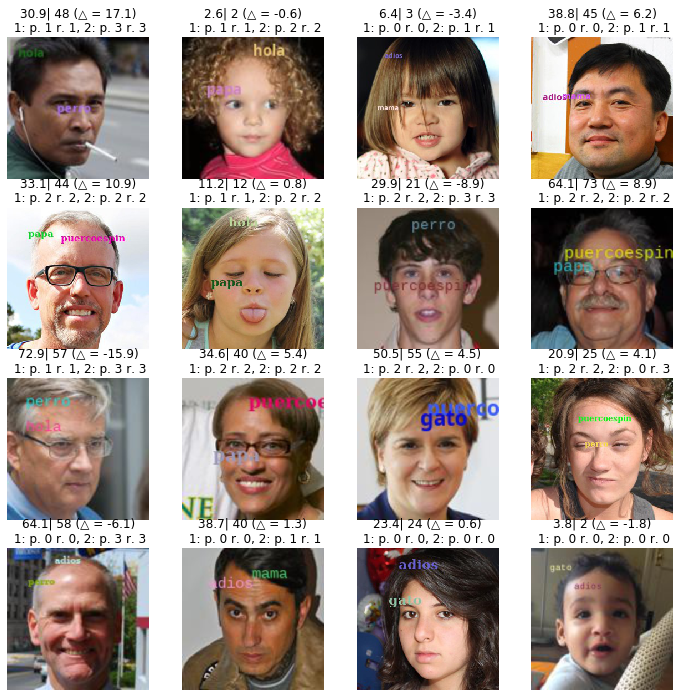

In [ ]:
learner.show_results()